This notebook will be collected automatically at **6pm on Monday** from `/home/data_scientist/assignments/Week11` directory on the course JupyterHub server. If you work on this assignment on the course Jupyterhub server, just make sure that you save your work and instructors will pull your notebooks automatically after the deadline. If you work on this assignment locally, the only way to submit assignments is via Jupyterhub, and you have to place the notebook file in the correct directory with the correct file name before the deadline.

1. Make sure everything runs as expected. First, restart the kernel (in the menubar, select `Kernel` → `Restart`) and then run all cells (in the menubar, select `Cell` → `Run All`).
2. Make sure you fill in any place that says `YOUR CODE HERE`. Do not write your answer in anywhere else other than where it says `YOUR CODE HERE`. Anything you write anywhere else will be removed by the autograder.
3. Do not change the file path or the file name of this notebook.
4. Make sure that you save your work (in the menubar, select `File` → `Save and CheckPoint`)

## Problem 11.2. Hierarchical Modeling.

In this problem, we will implement a hierarchical model to estimate the distribution of departure delays in December of 2001.

![](https://raw.githubusercontent.com/UI-DataScience/info490-sp16/master/Week11/assignments/images/hierarchical.png)

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm

from nose.tools import assert_equal, assert_true, assert_is_instance
from numpy.testing import assert_array_almost_equal, assert_almost_equal

We use the [airline on-time performance data](http://stat-computing.org/dataexpo/2009/). For simplicity, we limit our analysis to flights that departed from [CMI](https://en.wikipedia.org/wiki/University_of_Illinois_Willard_Airport) in December.

In [2]:
filename = '/home/data_scientist/data/2001.csv'

usecols = (1, 2, 15, 16)
columns = ['Month', 'DayofMonth', 'DepDelay', 'Origin']

all_data = pd.read_csv(filename, header=0, na_values=['NA'], usecols=usecols, names=columns)

local = all_data[
    (all_data['Origin'] == 'CMI') & # use only flights departed from Chicago
    (all_data['Month'] == 12) # consider only December
    ]
local = local.drop(['Month', 'Origin'], axis=1) # we don't need Month and Origin columns
local = local.dropna() # drop missing values

print(local.head())

         DayofMonth  DepDelay
5830137           1        -8
5830138           2        38
5830139           3        -8
5830140           4         0
5830141           5        -1


We will use a [Poisson distribution](https://en.wikipedia.org/wiki/Poisson_distribution) (see the next section) but the Poisson distribution does not allow negative means. That is, $\mu > 0$ in

$$ Poisson(\mu) = P(x\mid\mu) = \frac{e^{-\mu}\mu^{x}}{x!}\quad\textrm{for}\, x=0,1,2,\cdots $$

However, there are some negative values in `DepDelay`.

In [3]:
print(local.DepDelay.min())

-13.0


This condition can be avoided by a simple shift in the domain, so let's add 15 minutes to all departure delays.

In [4]:
def shift_column(df, field, shift):
    return pd.concat([df.drop(field, axis=1), df[field].apply(lambda x: x + shift)], axis=1) 

local_shifted = shift_column(local, 'DepDelay', 15)

print(local_shifted.head())

         DayofMonth  DepDelay
5830137           1         7
5830138           2        53
5830139           3         7
5830140           4        15
5830141           5        14


The following code cell asserts that all values in `DepDelay` are non-negative.

In [5]:
assert_equal((local_shifted.DepDelay.values < 0).sum(), 0)

For simplicity, let's remove some outliers and only consider departure delays less than 60 minutes.

In [6]:
local_shifted = local_shifted[local_shifted['DepDelay'] < 60]
# check if there are any values greater than 60
assert_equal((local_shifted.DepDelay.values > 60).sum(), 0)

In the following section, we model each day independently, modeling paramters $\mu_i$ of the Poisson distribution for each day of December, $i=1, 2, \cdots, 31$. The reasoning behind this is that the departure delays will depend on different conditions of each day, e.g. the weather, whether it's a weekend or a weekday, whehter it's a holiday, etc.

Simiarly to the use of `county_idx` in [one of the required readings](http://pymc-devs.github.io/pymc3/GLM-hierarchical/), we need a way to map `mu` (an array of length 31) to an array that has the length as `local_shifted`. Read the required readings to see how `county_idx` is used [here](http://pymc-devs.github.io/pymc3/GLM-hierarchical/) and how `participants_idx` is used [here](http://nbviewer.jupyter.org/github/markdregan/Bayesian-Modelling-in-Python/blob/master/Section%203.%20Hierarchical%20modelling.ipynb). 

We can use the `DayofMonth` column to create `date_idx`:

In [7]:
date_idx = local_shifted['DayofMonth'].values - 1
print(date_idx)

[ 0  1  2  3  4  5  6  8  9 10 11 12 13 14 15 17 18 19 21 22 23 24 25 26 27
 28 29 30  0  1  2  3  4  5  6  7  8 10 12 14 16 17 18 20 25 26 28 29 30  0
  1  3  4  5  6  7  8  9 10 12 14 15 16 18 20 21 22 24 26 27 28 29 30  2  3
  4  5  6  8  9 10 11 12 13 14 16 17 18 19 20 21 22 23 24 25 27 28 29 30  0
  2  3  4  8  9 10 11 13 15 17 18 19 20 21 22 23 24 25 26 27 29]


And we can use `date_idx` as follows:

```python
>>> mu = np.arange(31)
>>> print(mu)
```
```
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
```
```python
>>> print(mu[date_idx])
```
```
[ 0  1  2  3  4  5  6  8  9 10 11 12 13 14 15 17 18 19 21 22 23 24 25 26 27
 28 29 30  0  1  2  3  4  5  6  7  8 10 12 14 16 17 18 20 25 26 28 29 30  0
  1  3  4  5  6  7  8  9 10 12 14 15 16 18 20 21 22 24 26 27 28 29 30  2  3
  4  5  6  8  9 10 11 12 13 14 16 17 18 19 20 21 22 23 24 25 27 28 29 30  0
  2  3  4  8  9 10 11 13 15 17 18 19 20 21 22 23 24 25 26 27 29]
```
```python
>>> len(mu[date_idx]) == len(local_shifted)
```
```
True
```

## Hierarchical Model

- Implement the following hierarchical model using `pymc3`:
$$
\begin{aligned}
y_{ji} &\sim Poisson(\mu_{i}) \\
\mu_i &= Gamma(\alpha_\mu, \beta_\mu) \\
\alpha_\mu &= Gamma(1, 1) \\
\beta_\mu &= Gamma(1, 1)
\end{aligned}
$$
for each flight $j$ and each day $i$.

  Note there are two ways to specify a [Gamma distribution](https://en.wikipedia.org/wiki/Gamma_distribution): either in terms of alpha and beta or mean and standard deviation. In this problem, we parametrize it in terms of alpha (the shape parameter) and beta (the rate parameter).

- Use the names `mu`, `hyper_alpha_mu`, and `hyper_beta_mu` for $\mu_i$, $\alpha_\mu$, and $\beta_\mu$, respectively.
- Estimate the model paramters with the maximum a posteriori (MAP) method.
- Use the `Metropolis` sampler to generate posterior samples.
- Use the `random_seed` parameter in `pymc3.sample()` method for reproducibility.
- Use the name `y_pred` for posterior predictive distribution.

In [8]:
def sample_posterior(X, idx, n_samples=2000, random_seed=0):
    '''
    A hierarchical Poisson model.
    
    Paramters
    ---------
    X: A numpy array
    y: A numpy array
    n_samples: The number of samples to draw in pymc3.sample().
               Defaults to 2000.
    random_seed: An int. Used in pymc3.sample().
                 Defaults to 0.
                 
    Returns
    -------
    A pymc3.MultiTrace object with access to sampling values.
    '''
    
    # YOUR CODE HERE
    
    with pm.Model() as hierarchical_model:
        # define parameters
        hyper_alpha_mu = pm.Gamma('hyper_alpha_mu', alpha=1.0, beta=1.0)
        hyper_beta_mu = pm.Gamma('hyper_beta_mu', alpha=1.0, beta=1.0)
        
        mu = pm.Gamma('mu', alpha=hyper_alpha_mu, beta=hyper_beta_mu, shape=31)

        # Expected values using original indepedent variables
        # Deterministic Variable
        y_est = pm.Poisson('y_est', mu=mu[idx], observed=X)

        y_pred = pm.Poisson('y_pred', mu=mu[idx], shape=len(X))
        
        start = pm.find_MAP()
        step = pm.Metropolis()
        trace = pm.sample(n_samples, step=step, start=start, random_seed=random_seed)
    
    return trace

In [9]:
hierarchical_trace = sample_posterior(X=local_shifted['DepDelay'].values, idx=date_idx, n_samples=80000, random_seed=0)

Applied log-transform to hyper_alpha_mu and added transformed hyper_alpha_mu_log to model.
Applied log-transform to hyper_beta_mu and added transformed hyper_beta_mu_log to model.
Applied log-transform to mu and added transformed mu_log to model.
 [-----------------100%-----------------] 80000 of 80000 complete in 44.9 sec

## Tests

In [10]:
assert_is_instance(hierarchical_trace, pm.backends.base.MultiTrace)

In [11]:
assert_true('mu' in hierarchical_trace.varnames)
assert_true('hyper_alpha_mu' in hierarchical_trace.varnames)
assert_true('hyper_beta_mu' in hierarchical_trace.varnames)

In [12]:
for v in hierarchical_trace.varnames:
    assert_equal(len(hierarchical_trace[v]), 80000)
    
assert_equal(hierarchical_trace['mu'].shape[1], 31)

In [13]:
# note the length of array is 31 for 31 days in the month
assert_array_almost_equal(
    hierarchical_trace['mu'][0],
    [5.15005592, 16.62475099, 5.03444127, 5.40358024, 8.40843765,
     5.61251445, 9.65902676, 8.29027816, 5.77918743, 7.80919257,
     6.71820538, 11.21074815, 11.27763165, 7.45102395, 13.82115365,
     12.8650268, 9.40608051, 7.2311194, 12.6340181, 13.3161937,
     13.35869537, 6.9998901, 5.72812909, 5.64635636, 4.68759737,
     8.84972429, 10.81517311, 7.23111938, 4.57198273, 9.0657502,
     4.57198273]
   )
assert_almost_equal(hierarchical_trace['hyper_alpha_mu'][0], 5.5450169149287056)
assert_almost_equal(hierarchical_trace['hyper_beta_mu'][0], 0.64942390716757559)

In [14]:
assert_array_almost_equal(
    hierarchical_trace['mu'][-1],
    [8.08654949,  34.08375562,   7.57008048,  10.51196284,
     18.50107316,  11.78745225,  18.09940971,  16.12241449,
     12.13169846,  12.99963019,  13.07349378,  21.31053712,
     27.4765663 ,  11.39435597,  28.41184322,  22.4256777 ,
     16.35230358,  12.67814559,  26.50712586,  24.2461485 ,
     21.82843992,  15.66077269,   7.92093995,  10.11164244,
     8.82131075,  19.24463485,  23.58609886,  13.27383154,
     8.12750498,  16.63355877,   7.75384533]
     )
assert_array_almost_equal(
    hierarchical_trace['hyper_alpha_mu'][-5:],
    [ 4.80090336,  4.90969099,  4.92489938,  4.63708025,  4.63708025]
    )
assert_array_almost_equal(
    hierarchical_trace['hyper_beta_mu'][-5:],
    [ 0.29688425,  0.29688425,  0.29688425,  0.29688425,  0.29688425]
)

## Model Checking

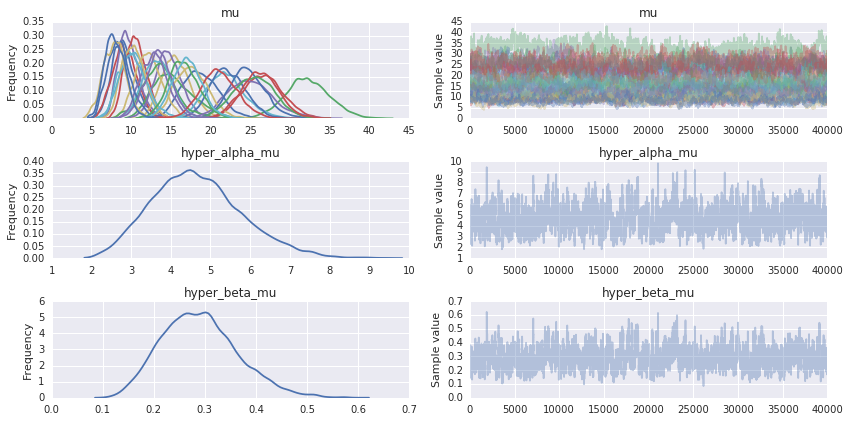

In [15]:
pm.traceplot(hierarchical_trace[40000:], varnames=['mu', 'hyper_alpha_mu', 'hyper_beta_mu']);

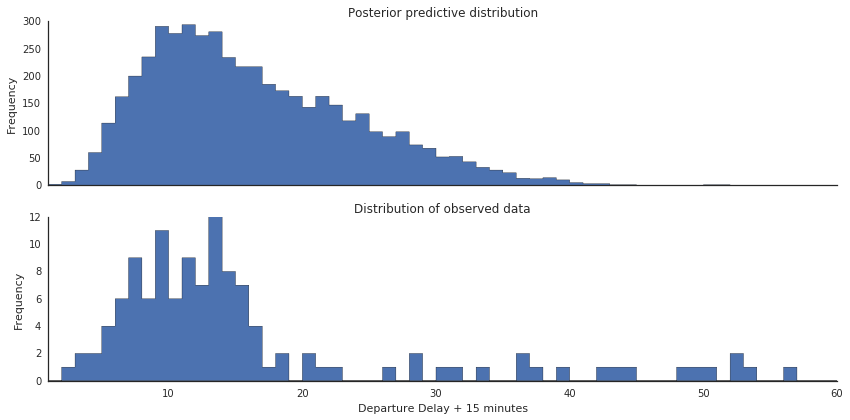

In [16]:
x_lim = 60
n_burn = 40000

# we discard burn-in and use every 1000th trace
y_pred = hierarchical_trace.get_values('y_pred')[n_burn::1000].ravel()

sns.set_style('white')
fig, ax = plt.subplots(2, sharex=True, figsize=(12,6))

ax[0].hist(y_pred, range=[0, x_lim], bins=x_lim, histtype='stepfilled')   
ax[0].set_xlim(1, x_lim)
ax[0].set_ylabel('Frequency')
ax[0].set_title('Posterior predictive distribution')

ax[1].hist(local_shifted.DepDelay.values, range=[0, x_lim], bins=x_lim, histtype='stepfilled')
ax[1].set_xlabel('Departure Delay + 15 minutes')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Distribution of observed data')

sns.despine()

plt.tight_layout()

plt.show()